In [66]:
# To upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"lvemavar","key":"f4ffd802fe008780668fe22faa542da7"}'}

In [67]:
!mkdir ~/.kaggle


# Changing the prath to the .kaggle folder
!cp kaggle.json ~/.kaggle/
#  Changing the permissions to perform read and write access
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [68]:
# Downloading the dogs-vs-cats dataset
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [69]:
# Unzipping dogs-vs-cats dataset file
!unzip -qq dogs-vs-cats.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [70]:
# Unzipping train sample
!unzip -qq train.zip

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [74]:
!pip install tensorflow==2.12


In [76]:
# Creating directories and assiging images to training, validation and test directories
import os, shutil, pathlib

#shutil.rmtree("cats_vs_dogs_small")

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


In [77]:
#Building the model and running the model summary
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

In [78]:
# Configuration of the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [79]:
# Declaring the image size and batch size to read the images from train. validation and test directories
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [80]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 63ms/step - loss: 0.6980 - accuracy: 0.4865 - val_loss: 0.6901 - val_accuracy: 0.5290
Epoch 2/30
63/63 [==============================] - 8s 117ms/step - loss: 0.6940 - accuracy: 0.5425 - val_loss: 0.6876 - val_accuracy: 0.5200
Epoch 3/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6761 - accuracy: 0.5860 - val_loss: 0.6451 - val_accuracy: 0.6260
Epoch 4/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6484 - accuracy: 0.6290 - val_loss: 0.7126 - val_accuracy: 0.5430
Epoch 5/30
63/63 [==============================] - 7s 115ms/step - loss: 0.6133 - accuracy: 0.6730 - val_loss: 0.6514 - val_accuracy: 0.6460
Epoch 6/30
63/63 [==============================] - 4s 60ms/step - loss: 0.5773 - accuracy: 0.7115 - val_loss: 0.6762 - val_accuracy: 0.6330
Epoch 7/30
63/63 [==============================] - 4s 60ms/step - loss: 0.5258 - accuracy: 0.7390 - val_loss: 0.6151 - val_accuracy: 0.6800
Epoch 8/30


In [81]:
# Testing the model
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 66ms/step - loss: 0.5760 - accuracy: 0.7415
Test accuracy: 0.742


In [82]:
# Declaring Data Augumentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [83]:

# Building the model and configuing it
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [84]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 11s 120ms/step - loss: 0.7178 - accuracy: 0.4830 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6945 - accuracy: 0.5190 - val_loss: 0.7650 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6979 - accuracy: 0.5105 - val_loss: 0.6901 - val_accuracy: 0.5070
Epoch 4/100
63/63 [==============================] - 6s 82ms/step - loss: 0.7013 - accuracy: 0.5495 - val_loss: 0.6768 - val_accuracy: 0.6240
Epoch 5/100
63/63 [==============================] - 5s 81ms/step - loss: 0.6764 - accuracy: 0.5970 - val_loss: 0.6856 - val_accuracy: 0.5740
Epoch 6/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6592 - accuracy: 0.6240 - val_loss: 0.6776 - val_accuracy: 0.6070
Epoch 7/100
63/63 [==============================] - 5s 83ms/step - loss: 0.6498 - accuracy: 0.6335 - val_loss: 0.6527 - val_accuracy: 0.5990
Epoc

In [85]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 66ms/step - loss: 0.4408 - accuracy: 0.8040
Test accuracy: 0.804


In [86]:
# Creating directories and assiging images to training, validation and test directories
# Increasing the training sample from 1000 to 2000
import os
import shutil
import pathlib
shutil.rmtree("cats_vs_dogs_small_IncreasedTrainSample")
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_IncreasedTrainSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Training has 2000 samples, test has 1000 samples, and validation has 500 samples
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3500)

In [87]:
# Building the model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [88]:
# Configuring the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [89]:
 # Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history= model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 61ms/step - loss: 0.7100 - accuracy: 0.5265 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 6s 100ms/step - loss: 0.6937 - accuracy: 0.5500 - val_loss: 0.6867 - val_accuracy: 0.5330
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6791 - accuracy: 0.5850 - val_loss: 0.6669 - val_accuracy: 0.5930
Epoch 4/30
63/63 [==============================] - 6s 85ms/step - loss: 0.6483 - accuracy: 0.6245 - val_loss: 0.6053 - val_accuracy: 0.6680
Epoch 5/30
63/63 [==============================] - 6s 85ms/step - loss: 0.6083 - accuracy: 0.6635 - val_loss: 0.9507 - val_accuracy: 0.5580
Epoch 6/30
63/63 [==============================] - 4s 59ms/step - loss: 0.5924 - accuracy: 0.6940 - val_loss: 0.6586 - val_accuracy: 0.6560
Epoch 7/30
63/63 [==============================] - 4s 60ms/step - loss: 0.5555 - accuracy: 0.7170 - val_loss: 0.5884 - val_accuracy: 0.6890
Epoch 8/30
6

In [90]:
# Testing the model
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 38ms/step - loss: 0.5660 - accuracy: 0.7120
Test accuracy: 0.712


In [91]:
# Creating directories and assiging images to training, validation and test directories
# Increasing the training sample from 1000 to 2000
import os
import shutil
import pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_OptimalTrainSamples1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Training has 1500 samples, test has 1000 samples, and validation has 500 samples
# make_subset("train", start_index=0, end_index=3500)
# make_subset("validation", start_index=2500, end_index=3000)
# make_subset("test", start_index=3000, end_index=4000)



In [92]:
# Building the model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [93]:
# Configuring the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [94]:
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator


# Train the model with varying training sample sizes
sample_sizes = [3500,4000,4500,5000]
history_dict = []
for size in sample_sizes:
    # Set up the training subset
    make_subset("temp_train", start_index=1500, end_index=size)
    make_subset("validation", start_index=size, end_index=size+500)
    make_subset("test", start_index=size+500, end_index=size+1500)
    train_dataset = image_dataset_from_directory(
      new_base_dir / "temp_train",
      image_size=(180, 180),
      batch_size=20)
    # Using the callbacks function to monitor validation loss and running the model

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")]

    history = model.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=callbacks)

    test_model = keras.models.load_model("convnet_from_scratch.keras")
    test_loss, test_acc = test_model.evaluate(test_dataset)
    history_dict.append(test_acc)
    print(f"Test accuracy: {test_acc:.3f}")

Found 4000 files belonging to 2 classes.
Epoch 1/30
200/200 [==============================] - 32s 53ms/step - loss: 0.7089 - accuracy: 0.5275 - val_loss: 0.6772 - val_accuracy: 0.6020
Epoch 2/30
200/200 [==============================] - 11s 52ms/step - loss: 0.6686 - accuracy: 0.5990 - val_loss: 0.6124 - val_accuracy: 0.6720
Epoch 3/30
200/200 [==============================] - 8s 39ms/step - loss: 0.6362 - accuracy: 0.6530 - val_loss: 0.5856 - val_accuracy: 0.7040
Epoch 4/30
200/200 [==============================] - 9s 47ms/step - loss: 0.5618 - accuracy: 0.7153 - val_loss: 0.5266 - val_accuracy: 0.7440
Epoch 5/30
200/200 [==============================] - 7s 35ms/step - loss: 0.5267 - accuracy: 0.7375 - val_loss: 0.5355 - val_accuracy: 0.7050
Epoch 6/30
200/200 [==============================] - 10s 49ms/step - loss: 0.4819 - accuracy: 0.7735 - val_loss: 0.4794 - val_accuracy: 0.7710
Epoch 7/30
200/200 [==============================] - 7s 35ms/step - loss: 0.4431 - accuracy: 0.78

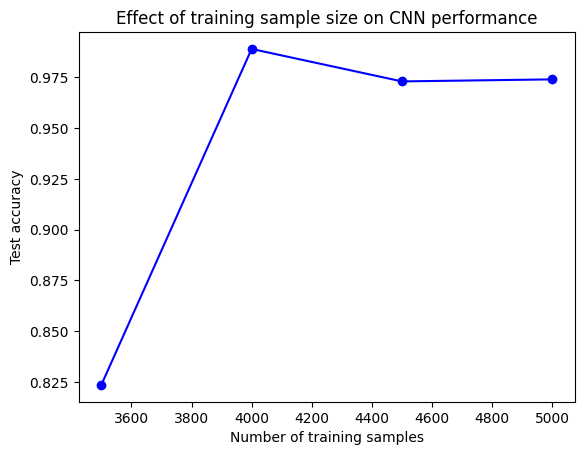

In [95]:
import matplotlib.pyplot as plt
plt.plot(sample_sizes, history_dict, 'bo-')
plt.xlabel('Number of training samples')
plt.ylabel('Test accuracy')
plt.title('Effect of training sample size on CNN performance')
plt.show()


In [96]:
# Creating directories and assiging images to training, validation and test directories
import os
import shutil
import pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Pretrained")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Training has 1500 samples, test has 500 samples, and validation has 500 samples
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [97]:
# Loading pre-trained weights to VGG16 model
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [98]:
# Defining function to extract features and labels
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
# Extracting the features and labels from datasets
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)
train_features.shape

1/1 [==============================] - 1s 576ms/step


(7000, 5, 5, 512)

In [99]:
# Building the model
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Running the callback function to monitor validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

# Training the model
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 9.4584 - accuracy: 0.9489 - val_loss: 3.8037 - val_accuracy: 0.9750
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 3.3019 - accuracy: 0.9791 - val_loss: 6.5085 - val_accuracy: 0.9650
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 1.9876 - accuracy: 0.9857 - val_loss: 13.8551 - val_accuracy: 0.9460
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 1.3396 - accuracy: 0.9907 - val_loss: 5.8428 - val_accuracy: 0.9660
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 1.1628 - accuracy: 0.9906 - val_loss: 3.1471 - val_accuracy: 0.9790
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.8689 - accuracy: 0.9921 - val_loss: 4.9840 - val_accuracy: 0.9730
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.5551 - accuracy: 0.9947 - val_loss: 4.7528 - val_accuracy: 0.9750
Epoch

In [100]:

# Testing the model
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 0.2106 - accuracy: 0.9975
Test accuracy: 0.998


In [101]:
# Loading pre-trained weights to the VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
# Freezing the layers of the pretrained CNN
conv_base.trainable = False

# UnFreezing the layers of the pretrained CNN
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [102]:
 # Declaring Data Augumentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
# Building the model and configuring it
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [103]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
350/350 [==============================] - 19s 46ms/step - loss: 10.6124 - accuracy: 0.9264 - val_loss: 3.9107 - val_accuracy: 0.9660
Epoch 2/50
350/350 [==============================] - 16s 45ms/step - loss: 5.4293 - accuracy: 0.9523 - val_loss: 2.0119 - val_accuracy: 0.9810
Epoch 3/50
350/350 [==============================] - 17s 48ms/step - loss: 3.5505 - accuracy: 0.9574 - val_loss: 1.6499 - val_accuracy: 0.9770
Epoch 4/50
350/350 [==============================] - 17s 47ms/step - loss: 2.1555 - accuracy: 0.9571 - val_loss: 0.8790 - val_accuracy: 0.9810
Epoch 5/50
350/350 [==============================] - 17s 47ms/step - loss: 1.2806 - accuracy: 0.9573 - val_loss: 0.6935 - val_accuracy: 0.9800
Epoch 6/50
350/350 [==============================] - 16s 44ms/step - loss: 1.1225 - accuracy: 0.9573 - val_loss: 0.7173 - val_accuracy: 0.9740
Epoch 7/50
350/350 [==============================] - 15s 43ms/step - loss: 0.8913 - accuracy: 0.9631 - val_loss: 0.5579 - val_accuracy

In [104]:
# Testing the model
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 5s 74ms/step - loss: 0.2300 - accuracy: 0.9890
Test accuracy: 0.989


In [105]:
# Creating directories and assiging images to training, validation and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_PretrainedIncreasedSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [106]:
# Loading pre-trained weights to VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
# conv_base.trainable = False

In [107]:

# Using the callbacks function to monitor validation loss and running the model
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=3000)

# Building the model
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Running the callback function to monitor validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

# Training the model
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
219/219 [==============================] - 3s 11ms/step - loss: 11.3929 - accuracy: 0.9520 - val_loss: 5.3427 - val_accuracy: 0.9660
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 3.4250 - accuracy: 0.9781 - val_loss: 15.7410 - val_accuracy: 0.9420
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 2.2616 - accuracy: 0.9846 - val_loss: 6.3649 - val_accuracy: 0.9670
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 1.3487 - accuracy: 0.9891 - val_loss: 3.7251 - val_accuracy: 0.9800
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 1.2111 - accuracy: 0.9901 - val_loss: 6.7381 - val_accuracy: 0.9690
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.5881 - accuracy: 0.9944 - val_loss: 4.6597 - val_accuracy: 0.9730
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.3573 - accuracy: 0.9963 - val_loss: 6.5061 - val_accuracy: 0.9740
Epo

In [108]:
# Testing the model
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 0.0522 - accuracy: 0.9990
Test accuracy: 0.999


In [109]:
# Creating directories and assiging images to training, validation and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_PretrainedoptimalSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [110]:

# Loading pre-trained weights to VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [111]:
# Building the model
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [112]:
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

# Train the model with varying training sample sizes
sample_sizes = [2500,3000,4000,5000]
history_dict = []
for size in sample_sizes:
    # Set up the training subset
    make_subset("temp_train", start_index=0, end_index=size)
    make_subset("validation", start_index=size, end_index=size+500)
    make_subset("test", start_index=size+500, end_index=size+1500)
    train_dataset = image_dataset_from_directory(
      new_base_dir / "temp_train",
      image_size=(180, 180),
      batch_size=20)
    # Running the callback function to monitor validation loss
    callbacks = [
      keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")]

    # Training the model
    history = model.fit(
      train_features, train_labels,
      epochs=20,
      validation_data=(val_features, val_labels),
      callbacks=callbacks)

   # Testing the model
    test_model = keras.models.load_model("feature_extraction.keras")
    test_loss, test_acc = test_model.evaluate(test_features, test_labels)
    print(f"Test accuracy: {test_acc:.3f}")

Found 5000 files belonging to 2 classes.
Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 9.8640 - accuracy: 0.9499 - val_loss: 4.4913 - val_accuracy: 0.9680
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 3.3770 - accuracy: 0.9776 - val_loss: 2.2289 - val_accuracy: 0.9760
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 1.6591 - accuracy: 0.9849 - val_loss: 2.4760 - val_accuracy: 0.9820
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 1.1310 - accuracy: 0.9900 - val_loss: 5.1928 - val_accuracy: 0.9700
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.5570 - accuracy: 0.9949 - val_loss: 3.4917 - val_accuracy: 0.9730
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.7342 - accuracy: 0.9937 - val_loss: 2.5562 - val_accuracy: 0.9780
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.6342 - accuracy: 0.9931 - val_l